<a href="https://colab.research.google.com/github/Fuhui-Chen/Fastbook-Practice/blob/master/04_mnist_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **try to create a model that can classify any image as a 3 or a 7**

In [0]:
pip install fastai2

In [0]:
from fastai2.vision.all import * #imports all of the fastai.vision library

In [0]:

path = untar_data(URLs.MNIST_SAMPLE)   # download a sample of MNIST that contains images of 3 and 7

In [0]:
#hide
Path.BASE_PATH = path

In [253]:
path.ls() #see what's in this directory by using ls, a method added by fastai. This method returns an object of a special fastai class called L, which has all the same functionality of Python's built-in list

(#3) [Path('labels.csv'),Path('valid'),Path('train')]

In [0]:
(path/'train').ls() #see what's inside the training set

(#2) [Path('train/7'),Path('train/3')]

In [0]:

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [0]:

im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [0]:

array(im3)[4:10,4:10] #converted a image to a NumPy array

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [0]:

tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [0]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')  #slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


# *First Try: Pixel Similarity¶*

Find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.


Step one for our simple model is to get the average of pixel values for each of our two groups. In the process of doing this, we will learn a lot of neat Python numeric programming tricks!

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.

In [0]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

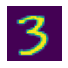

In [0]:
show_image(three_tensors[1]); # check that one of the images looks okay


For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a rank-3 tensor. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called stack that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to cast our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to float now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

In [0]:

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [0]:
len(stacked_threes.shape) #The length of a tensor's shape is its rank

3

In [0]:
stacked_threes.ndim # get a tensor's rank directly with ndim

3


Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

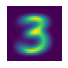

In [0]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

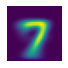

In [0]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);          #compute what the ideal 3 looks like

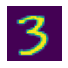

In [0]:
a_3 = stacked_threes[1]  #pick an arbitrary 3 and measure its distance from our "ideal digits
show_image(a_3);


How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

Take the mean of the absolute value of differences (absolute value is the function that replaces negative values with positive values). This is called the mean absolute difference or L1 norm
Take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring). This is called the root mean squared error (RMSE) or L2 norm.

In [0]:

dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [0]:

dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [0]:

F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

In [0]:
data = [[1,2,3],[4,5,6]]#To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to array() or tensor()
arr = array (data)
tns = tensor(data)

In [0]:

arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [0]:

tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [0]:
tns[:,1] #by using : to indicate all of the first axis

tensor([2, 5])

In [0]:

tns[1,1:3] #You can combine these with Python slice syntax ([start:end] with end being excluded) to select part of a row or column

tensor([5, 6])

In [0]:

tns+1 #use the standard operators such as +, -, *, /

tensor([[2, 3, 4],
        [5, 6, 7]])

In [0]:
tns.type() #Tensors have a type

'torch.LongTensor'

In [0]:
tns*1.5 #will automatically change type as needed, for example from int to float

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

# Computing Metrics Using Broadcasting

create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image

In [146]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

 write a simple function that calculates the mean absolute error using an experssion very similar to the one we wrote in the last section:

In [145]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

But in order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for every image in the validation set. How do we do that calculation? We could write a loop over all of the single-image tensors that are stacked within our validation set tensor, valid_3_tens, which has a shape of [1010,28,28] representing 1,010 images. But there is a better way.

Something very interesting happens when we take this exact same distance function, designed for comparing two single images, but pass in as an argument valid_3_tens, the tensor that represents the 3s validation set:

In [144]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1296, 0.1130, 0.1181,  ..., 0.1294, 0.1222, 0.1167]),
 torch.Size([1010]))

In [143]:

tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [142]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

We can use mnist_distance to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [0]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [141]:

is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [139]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s

In [138]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

# Stochastic Gradient Descent (SGD)

1.Initialize the weights.
2.For each image, use these weights to predict whether it appears to be a 3 or a 7.
3.Based on these predictions, calculate how good the model is (its loss).
4.Calculate the gradient, which measures for each weight, how changing that weight would change the loss
5.Step (that is, change) all the weights based on that calculation.
6.Go back to the step 2, and repeat the process.
7.Iterate until you decide to stop the training process (for instance, because the model is good enough or you don't want to wait any longer).

In [0]:

import matplotlib as mpl
# mpl.rcParams['figure.dpi']= 200
mpl.rcParams['savefig.dpi']= 200
mpl.rcParams['font.size']=12

set_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
pd.set_option('display.max_columns',999)
np.set_printoptions(linewidth=200)
torch.set_printoptions(linewidth=200)


In [0]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"' + s + '; }')

def get_image_files_sorted(path, recurse=True, folders=None): return get_image_files(path, recurse, folders).sorted()



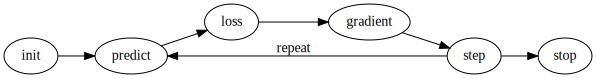

In [154]:
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

Before applying these steps to our image classification problem, let's illustrate what they look like in a simpler case. First we will define a very simple function, the quadratic—let's pretend that this is our loss function, and x is a weight parameter of the function

In [0]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)

In [0]:
def f(x): return x**2

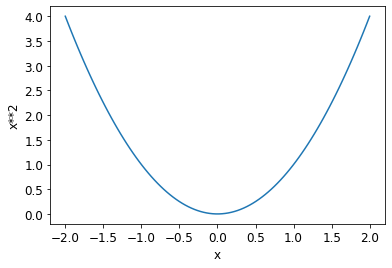

In [159]:

plot_function(f, 'x', 'x**2')


The sequence of steps we described earlier starts by picking some random value for a parameter, and calculating the value of the loss:

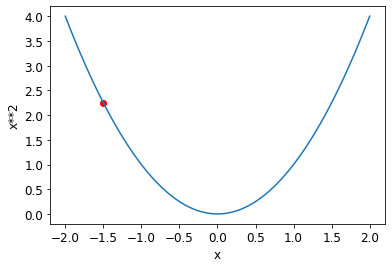

In [160]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

# Calculating Gradients

First, let's pick a tensor value which we want gradients at:

In [0]:

xt = tensor(3.).requires_grad_()

Now we calculate our function with that value. Notice how PyTorch prints not just the value calculated, but also a note that it has a gradient function it'll be using to calculate our gradients when needed:

In [162]:
yt = f(xt)
yt


tensor(9., grad_fn=<PowBackward0>)

Finally, we tell PyTorch to calculate the gradients for us

In [0]:
yt.backward()

We can now view the gradients by checking the grad attribute of our tensor:

In [164]:

xt.grad

tensor(6.)

Now we'll repeat the preceding steps, but with a vector argument for our function

In [165]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

And we'll add sum to our function so it can take a vector (i.e., a rank-1 tensor), and return a scalar (i.e., a rank-0 tensor):

In [166]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Our gradients are 2*xt, as we'd expect!

In [167]:

yt.backward()
xt.grad

tensor([ 6.,  8., 20.])


# An End-to-End SGD Example

Imagine you were measuring the speed of a roller coaster as it went over the top of a hump. It would start fast, and then get slower as it went up the hill; it would be slowest at the top, and it would then speed up again as it went downhill. You want to build a model of how the speed changes over time. If you were measuring the speed manually every second for 20 seconds, it might look something like this:

In [168]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

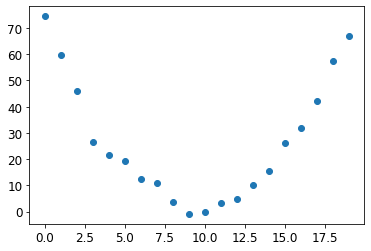

In [169]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

We want to distinguish clearly between the function's input (the time when we are measuring the coaster's speed) and its parameters (the values that define which quadratic we're trying). So, let's collect the parameters in one argument and thus separate the input, t, and the parameters, params, in the function's signature:

In [0]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

We need to define first what we mean by "best." We define this precisely by choosing a loss function, which will return a value based on a prediction and a target, where lower values of the function correspond to "better" predictions. For continuous data, it's common to use mean squared error:

In [0]:
def mse(preds, targets): return ((preds-targets)**2).mean()


Now, let's work through our 7 step process.

# Step 1: Initialize the parameters¶
First, we initialize the parameters to random values, and tell PyTorch that we want to track their gradients, using requires_grad_:

In [0]:

params = torch.randn(3).requires_grad_()

In [0]:
#hide
orig_params = params.clone()

# Step 2: Calculate the predictions
Next, we calculate the predictions:

In [0]:
preds = f(time, params)

Let's create a little function to see how close our predictions are to our targets, and take a look:

In [0]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

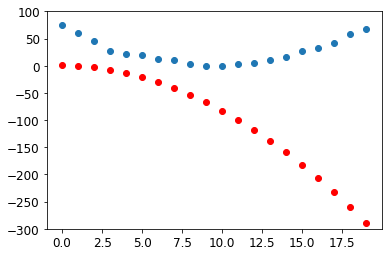

In [176]:
show_preds(preds)

# Step 3: Calculate the loss
We calculate the loss as follows:

In [177]:
loss = mse(preds, speed)
loss

tensor(25823.8086, grad_fn=<MeanBackward0>)


# Step 4: Calculate the gradients¶
The next step is to calculate the gradients. In other words, calculate an approximation of how the parameters need to change:

In [178]:

loss.backward()
params.grad

tensor([-53195.8594,  -3419.7146,   -253.8908])

In [179]:
params.grad * 1e-5

tensor([-0.5320, -0.0342, -0.0025])

We can use these gradients to improve our parameters. We'll need to pick a learning rate (we'll discuss how to do that in practice in the next chapter; for now we'll just use 1e-5, or 0.00001):

In [180]:
params

tensor([-0.7658, -0.7506,  1.3525], requires_grad=True)

# Step 5: Step the weights.
Now we need to update the parameters based on the gradients we just calculated:

In [0]:

lr = 1e-5
params.data -= lr * params.grad.data
params.grad = None

In [182]:
preds = f(time,params)
mse(preds, speed)

tensor(5435.5366, grad_fn=<MeanBackward0>)

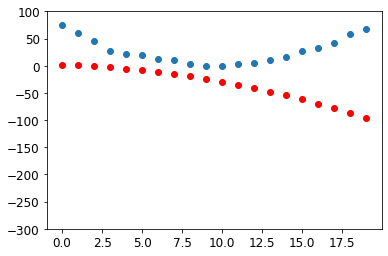

In [183]:
show_preds(preds)

We need to repeat this a few times, so we'll create a function to apply one step

In [0]:

def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

# Step 6: Repeat the process
Now we iterate. By looping and performing many improvements, we hope to reach a good result:

In [185]:

for i in range(10): apply_step(params)

5435.53662109375
1577.4495849609375
847.3780517578125
709.22265625
683.0757446289062
678.12451171875
677.1839599609375
677.0025024414062
676.96435546875
676.9537353515625


In [0]:

#hide
params = orig_params.detach().requires_grad_()


The loss is going down, just as we hoped! But looking only at these loss numbers disguises the fact that each iteration represents an entirely different quadratic function being tried, on the way to finding the best possible quadratic function. We can see this process visually if, instead of printing out the loss function, we plot the function at every step. Then we can see how the shape is approaching the best possible quadratic function for our data:

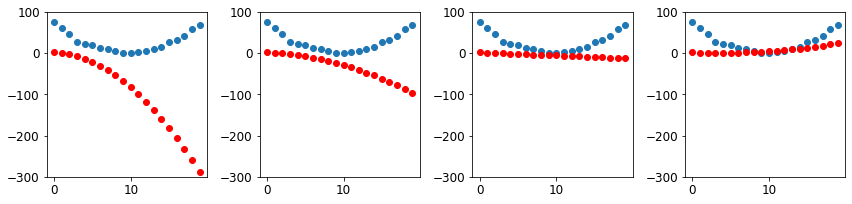

In [187]:

_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()


# Step 7: stop
We just decided to stop after 10 epochs arbitrarily. In practice, we would watch the training and validation losses and our metrics to decide when to stop, as we've discussed.


# Summarizing Gradient Descent

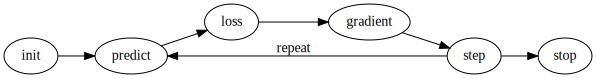

In [188]:
#hide_input
#id gradient_descent
#caption The gradient descent process
#alt Graph showing the steps for Gradient Descent
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

# The MNIST Loss Function

We already have our dependent variables x—these are the images themselves. We'll concatenate them all into a single tensor, and also change them from a list of matrices (a rank-3 tensor) to a list of vectors (a rank-2 tensor). We can do this using view, which is a PyTorch method that changes the shape of a tensor without changing its contents. -1 is a special parameter to view that means "make this axis as big as necessary to fit all the data":

In [0]:

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)


We need a label for each image. We'll use 1 for 3s and 0 for 7s:

In [190]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

A Dataset in PyTorch is required to return a tuple of (x,y) when indexed. Python provides a zip function which, when combined with list, provides a simple way to get this functionality:

In [191]:

dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

(torch.Size([784]), tensor([1]))

In [0]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

Now we need an (initially random) weight for every pixel (this is the initialize step in our seven-step process):

In [0]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [0]:

weights = init_params((28*28,1))


The function weights*pixels won't be flexible enough—it is always equal to 0 when the pixels are equal to 0 (i.e., its intercept is 0). You might remember from high school math that the formula for a line is y=w*x+b; we still need the b. We'll initialize it to a random number too:

In [0]:

bias = init_params(1)


We can now calculate a prediction for one image:

In [196]:

(train_x[0]*weights.T).sum() + bias

tensor([20.2336], grad_fn=<AddBackward0>)

In Python, matrix multiplication is represented with the @ operator. Let's try it:

In [197]:

def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[20.2336],
        [17.0644],
        [15.2384],
        ...,
        [18.3804],
        [23.8567],
        [28.6816]], grad_fn=<AddBackward0>)

Let's check our accuracy. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0, so our accuracy for each item can be calculated (using broadcasting, so no loops!) with:

In [198]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])

In [199]:

corrects.float().mean().item()

0.4912068545818329


Now let's see what the change in accuracy is for a small change in one of the weights

In [0]:
weights[0] *= 1.0001

In [201]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.4912068545818329

for instance, suppose we had three images which we knew were a 3, a 7, and a 3. And suppose our model predicted with high confidence (0.9) that the first was a 3, with slight confidence (0.4) that the second was a 7, and with fair confidence (0.2), but incorrectly, that the last was a 7. This would mean our loss function would receive these values as its inputs:

In [0]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

Here's a first try at a loss function that measures the distance between predictions and targets:

In [0]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

 try it on our prds and trgts:

In [204]:
torch.where(trgts==1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [205]:
mnist_loss(prds,trgts)

tensor(0.4333)

For instance, if we change our prediction for the one "false" target from 0.2 to 0.8 the loss will go down, indicating that this is a better prediction:

In [206]:

mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

tensor(0.2333)

# Sigmoid
The sigmoid function always outputs a number between 0 and 1. It's defined as follows:

In [0]:
def sigmoid(x): return 1/(1+torch.exp(-x))


Pytorch defines an accelerated version for us, so we don’t really need our own. This is an important function in deep learning, since we often want to ensure values are between 0 and 1. This is what it looks like:

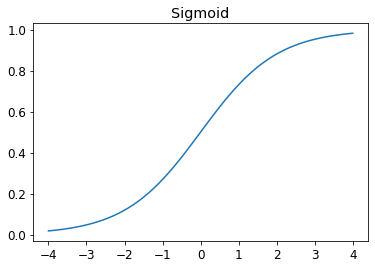

In [208]:

plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

Let's update mnist_loss to first apply sigmoid to the inputs:

In [0]:

def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

# SGD and Mini-Batches

A DataLoader can take any Python collection and turn it into an iterator over many batches, like so:

In [210]:

coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

[tensor([ 3, 12,  8, 10,  2]),
 tensor([ 9,  4,  7, 14,  5]),
 tensor([ 1, 13,  0,  6, 11])]

For training a model, we don't just want any Python collection, but a collection containing independent and dependent variables (that is, the inputs and targets of the model). A collection that contains tuples of independent and dependent variables is known in PyTorch as a Dataset. Here's an example of an extremely simple Dataset:

In [211]:
ds = L(enumerate(string.ascii_lowercase))
ds

(#26) [(0, 'a'),(1, 'b'),(2, 'c'),(3, 'd'),(4, 'e'),(5, 'f'),(6, 'g'),(7, 'h'),(8, 'i'),(9, 'j')...]

When we pass a Dataset to a DataLoader we will get back many batches which are themselves tuples of tensors representing batches of independent and dependent variables:

In [212]:

dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

[(tensor([17, 18, 10, 22,  8, 14]), ('r', 's', 'k', 'w', 'i', 'o')),
 (tensor([20, 15,  9, 13, 21, 12]), ('u', 'p', 'j', 'n', 'v', 'm')),
 (tensor([ 7, 25,  6,  5, 11, 23]), ('h', 'z', 'g', 'f', 'l', 'x')),
 (tensor([ 1,  3,  0, 24, 19, 16]), ('b', 'd', 'a', 'y', 't', 'q')),
 (tensor([2, 4]), ('c', 'e'))]

We are now ready to write our first training loop for a model using SGD!


# Putting It All Together
It's time to implement the process we saw in <

for x,y in dl:
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    parameters -= parameters.grad * lr


# First, let's re-initialize our parameters:

In [0]:

weights = init_params((28*28,1))
bias = init_params(1)

A DataLoader can be created from a Dataset:

In [214]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

We'll do the same for the validation set:

In [0]:
valid_dl = DataLoader(valid_dset, batch_size=256)


Let's create a mini-batch of size 4 for testing:

In [216]:

batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [217]:
preds = linear1(batch)
preds

tensor([[-2.1876],
        [-8.3973],
        [ 2.5000],
        [-4.9473]], grad_fn=<AddBackward0>)

In [218]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(0.7419, grad_fn=<MeanBackward0>)

Now we can calculate the gradients:

In [219]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

(torch.Size([784, 1]), tensor(-0.0061), tensor([-0.0420]))

Let's put that all in a function:

In [0]:

def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

and test it:

In [221]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0121), tensor([-0.0840]))


But look what happens if we call it twice:

In [222]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

(tensor(-0.0182), tensor([-0.1260]))


The gradients have changed! The reason for this is that loss.backward actually adds the gradients of loss to any gradients that are currently stored. So, we have to set the current gradients to 0 first:

In [0]:

weights.grad.zero_()
bias.grad.zero_();

Our only remaining step is to update the weights and biases based on the gradient and learning rate. When we do so, we have to tell PyTorch not to take the gradient of this step too—otherwise things will get very confusing when we try to compute the derivative at the next batch! If we assign to the data attribute of a tensor then PyTorch will not take the gradient of that step. Here's our basic training loop for an epoch:

In [0]:

def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()


We also want to check how we're doing, by looking at the accuracy of the validation set. To decide if an output represents a 3 or a 7, we can just check whether it's greater than 0. So our accuracy for each item can be calculated (using broadcasting, so no loops!) with

In [225]:

(preds>0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [ True],
        [False]])

That gives us this function to calculate our validation accuracy:

In [0]:

def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()


We can check it works:

In [227]:
batch_accuracy(linear1(batch), train_y[:4])

tensor(0.2500)


and then put the batches together:

In [0]:

def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [229]:
validate_epoch(linear1)

0.526

That's our starting point. Let's train for one epoch, and see if the accuracy improves:

In [230]:

lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

0.6663

Then do a few more:

In [231]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

0.8265 0.89 0.9183 0.9276 0.9398 0.9466 0.9505 0.9525 0.9559 0.9579 0.9598 0.9608 0.9613 0.9618 0.9633 0.9637 0.9647 0.9657 0.9672 0.9677 

Looking good! We're already about at the same accuracy as our "pixel similarity" approach, and we've created a general-purpose foundation we can build on. Our next step will be to create an object that will handle the SGD step for us. In PyTorch, it's called an optimizer.



# Creating an Optimizer
Because this is such a general foundation, PyTorch provides some useful classes to make it easier to implement. The first thing we can do is replace our linear function with PyTorch's nn.Linear module. A module is an object of a class that inherits from the PyTorch nn.Module class. Objects of this class behave identically to standard Python functions, in that you can call them using parentheses and they will return the activations of a model.

nn.Linear does the same thing as our init_params and linear together. It contains both the weights and biases in a single class. Here's how we replicate our model from the previous section:

In [0]:

linear_model = nn.Linear(28*28,1)

Every PyTorch module knows what parameters it has that can be trained; they are available through the parameters method:

In [233]:
w,b = linear_model.parameters()
w.shape,b.shape

(torch.Size([1, 784]), torch.Size([1]))

We can use this information to create an optimizer:

In [0]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

We can create our optimizer by passing in the model's parameters:

In [0]:
opt = BasicOptim(linear_model.parameters(), lr)

Our training loop can now be simplified to:

In [0]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()


Our validation function doesn't need to change at all:

In [237]:
validate_epoch(linear_model)

0.4607

Let's put our little training loop in a function, to make things simpler:

In [0]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

The results are the same as in the previous section:

In [239]:

train_model(linear_model, 20)

0.4932 0.7685 0.8554 0.9135 0.9345 0.9482 0.957 0.9633 0.9658 0.9677 0.9697 0.9716 0.9736 0.9746 0.976 0.977 0.9775 0.9775 0.978 0.9785 

fastai provides the SGD class which, by default, does the same thing as our BasicOptim:

In [240]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.8179 0.8496 0.914 0.9345 0.9482 0.957 0.9619 0.9658 0.9672 0.9692 0.9712 0.9741 0.9751 0.976 0.9775 0.9775 0.978 0.9785 0.979 

fastai also provides Learner.fit, which we can use instead of train_model. To create a Learner we first need to create a DataLoaders, by passing in our training and validation DataLoaders:

In [0]:
dls = DataLoaders(dl, valid_dl)

To create a Learner without using an application (such as cnn_learner) we need to pass in all the elements that we've created in this chapter: the DataLoaders, the model, the optimization function (which will be passed the parameters), the loss function, and optionally any metrics to print:

In [0]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

Now we can call fit:

In [243]:

learn.fit(10, lr=lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636709,0.503144,0.495584,00:00
1,0.429828,0.248517,0.777233,00:00
2,0.161680,0.155361,0.861629,00:00
3,0.072948,0.097722,0.917566,00:00
4,0.040128,0.073205,0.936212,00:00
5,0.027210,0.059466,0.950442,00:00
6,0.021837,0.050799,0.957802,00:00
7,0.019398,0.044980,0.964181,00:00
8,0.018122,0.040853,0.966143,00:00
9,0.017330,0.037788,0.968106,00:00



As you can see, there's nothing magic about the PyTorch and fastai classes. They are just convenient pre-packaged pieces that make your life a bit easier! (They also provide a lot of extra functionality we'll be using in future chapters.)

With these classes, we can now replace our linear model with a neural network.


# Adding a Nonlinearity
So far we have a general procedure for optimizing the parameters of a function, and we have tried it out on a very boring function: a simple linear classifier. A linear classifier is very constrained in terms of what it can do. To make it a bit more complex (and able to handle more tasks), we need to add something nonlinear between two linear classifiers—this is what gives us a neural network.

Here is the entire definition of a basic neural network:

In [0]:

def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res


That's it! All we have in simple_net is two linear classifiers with a max function between them.

Here, w1 and w2 are weight tensors, and b1 and b2 are bias tensors; that is, parameters that are initially randomly initialized, just like we did in the previous section:

In [0]:

w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)


The key point about this is that w1 has 30 output activations (which means that w2 must have 30 input activations, so they match). That means that the first layer can construct 30 different features, each representing some different mix of pixels. You can change that 30 to anything you like, to make the model more or less complex.

That little function res.max(tensor(0.0)) is called a rectified linear unit, also known as ReLU. We think we can all agree that rectified linear unit sounds pretty fancy and complicated... But actually, there's nothing more to it than res.max(tensor(0.0))—in other words, replace every negative number with a zero. This tiny function is also available in PyTorch as F.relu:

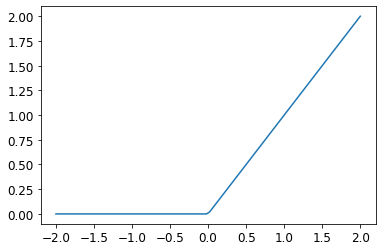

In [246]:
plot_function(F.relu)

In [0]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [0]:

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [249]:
#hide_output
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.333021,0.396112,0.512267,00:00
1,0.152461,0.235238,0.797350,00:00
2,0.083573,0.117471,0.911678,00:00
3,0.054309,0.078720,0.940628,00:00
4,0.040829,0.061228,0.956330,00:00
5,0.034006,0.051490,0.963690,00:00
6,0.030123,0.045381,0.966634,00:00
7,0.027619,0.041218,0.968106,00:00
8,0.025825,0.038200,0.969087,00:00
9,0.024441,0.035901,0.969578,00:00


We're not showing the 40 lines of output here to save room; the training process is recorded in learn.recorder, with the table of output stored in the values attribute, so we can plot the accuracy over training as:

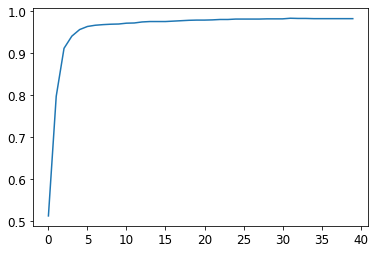

In [250]:
plt.plot(L(learn.recorder.values).itemgot(2));


And we can view the final accuracy:

In [251]:

learn.recorder.values[-1][2]

0.98233562707901

At this point we have something that is rather magical:

A function that can solve any problem to any level of accuracy (the neural network) given the correct set of parameters
A way to find the best set of parameters for any function (stochastic gradient descent)

# Going Deeper
There is no need to stop at just two linear layers. We can add as many as we want, as long as we add a nonlinearity between each pair of linear layers. As you will learn, however, the deeper the model gets, the harder it is to optimize the parameters in practice. Later in this book you will learn about some simple but brilliantly effective techniques for training deeper models.

We already know that a single nonlinearity with two linear layers is enough to approximate any function. So why would we use deeper models? The reason is performance. With a deeper model (that is, one with more layers) we do not need to use as many parameters; it turns out that we can use smaller matrices with more layers, and get better results than we would get with larger matrices, and few layers.

That means that we can train the model more quickly, and it will take up less memory. In the 1990s researchers were so focused on the universal approximation theorem that very few were experimenting with more than one nonlinearity. This theoretical but not practical foundation held back the field for years. Some researchers, however, did experiment with deep models, and eventually were able to show that these models could perform much better in practice. Eventually, theoretical results were developed which showed why this happens. Today, it is extremely unusual to find anybody using a neural network with just one nonlinearity.

Here what happens when we train an 18-layer model using the same approach we saw in <

In [252]:

dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.079625,0.016696,0.995093,02:53


Nearly 100% accuracy! That's a big difference compared to our simple neural net. But as you'll learn in the remainder of this book, there are just a few little tricks you need to use to get such great results from scratch yourself. You already know the key foundational pieces. 